In [1]:
import pandas as pd
import numpy as np 
from datetime import datetime as dt
import matplotlib.dates as mdates
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from ipywidgets import Dropdown
from matplotlib import pyplot as plt

In [2]:

# descomentar para versão online
#BASE_URL = "https://raw.githubusercontent.com/LFBossa/MapaSaudeSC/main/"
BASE_URL = "../"  
 
def get_dados():
    doenças = pd.read_csv(BASE_URL + "parsed-data/saude-series.csv")
    população = pd.read_csv(BASE_URL + "parsed-data/populacao.csv")
    regioes = pd.read_csv(BASE_URL + "data/geoloc/regioes-saude.csv",
                          dtype={"REGIAO": "category", "municipio": "str"})
    regioes.set_index("CODIBGE", inplace=True)
    população["região"] = população.COD_IBGE.apply(
        lambda x: regioes.loc[x, "REGIAO"])
    população.set_index("COD_IBGE", inplace=True)

    def get_pop(ibge, year):
        if year == 2022:
            year -= 1 
        return população.loc[ibge, str(year)]

    def get_pop_df(row):
        return get_pop(row["Ibge"], row["ano"])

    doenças["população"] = doenças.apply(get_pop_df, axis=1)
    doenças["região"] = doenças.Ibge.apply(lambda x: regioes.loc[x, "REGIAO"])

    return doenças, população, regioes


def pop_regiao(regiao, year):
    if year == 2022:
        year -= 1 
    return população_das_regiões.loc[regiao, str(year)]


def pop_estado(ano):
    if ano == 2022:
        ano -= 1 
    return população[str(ano)].sum()


```python
regiao_select = Dropdown(description='Região:',options=regioes.REGIAO.unique())
regiao_select
doenca_select = Dropdown(description="Doença:", options=doenças.columns[1:13])
doenca_select
regiao = regiao_select.value
doença = doenca_select.value

pvt_doença_região = pd.pivot_table(
    doenças[["referencia", "região", doença]], index="referencia", columns="região", aggfunc=sum)[(doença, regiao)]
população_região = [pop_regiao(regiao, ano)
                    for ano in (pvt_doença_região.index.values // 100)]
pvt_doença_estado = pd.pivot_table(
    doenças[["referencia", doença]], index="referencia",  aggfunc=sum)[doença]
população_estado = [pop_estado(ano) for ano in (
    pvt_doença_estado.index.values // 100)]

 

dadddos = pd.concat([pvt_doença_região/população_região*1000,
                     pvt_doença_estado/população_estado*1000], axis=1).sort_index().reset_index()
datas = [dt.strptime(str(x), "%Y%m") for x in dadddos["referencia"].values]
dadddos["referencia"] = datas
dadddos.set_index("referencia", inplace=True)
dadddos.columns = [regiao, "SC"]

source = ColumnDataSource(dadddos)
TOOLTIPS = HoverTool(
    tooltips=[
        ("data", "@referencia{%F}"), 
        ("região", f"@{{{regiao}}}"),
        ("estado", f"@{{SC}}"),
    ],
    formatters={
        '@referencia': 'datetime',  # use 'datetime' formatter for '@date' field
    },)

p = figure(title=f"Índice de {doença} para cada mil habitantes em {regiao}",
           x_axis_type='datetime') 
p.line(x="referencia", y=regiao, source=source,
       legend_label=regiao, alpha=0.7)
p.line(x="referencia", y="SC", source=source,
       legend_label="SC", alpha=0.6, line_dash="dashed",line_color="black")
p.add_tools(TOOLTIPS)
p.legend.location = 'top_left'

show(p)
```


> Interesse: diabetes, obesidade, hipertensao e tabagismo

In [12]:
doenças, população, regioes = get_dados()
população_das_regiões = população.groupby("região").sum()


In [5]:
doenças.columns[1:13]

Index(['Asma', 'Diabetes', 'DPOC', 'Hipertensão arterial', 'Obesidade',
       'Tabagismo', 'Usuário de álcool', 'Saúde mental',
       'D.Transmissíveis - Hanseníase', 'D.Transmissíveis - Tuberculose',
       'Rast. câncer de mama', 'Rast. câncer do colo do útero'],
      dtype='object')

In [16]:
#doenças_interesse = [ 'Diabetes', 'Hipertensão arterial', 'Obesidade', 'Tabagismo' ] 
doenças_interesse = doenças.columns[1:13]

In [7]:
MACRO_REGIOES = {
    "Grande Florianópolis": ["Grande Florianópolis"],
    "Grande Oeste": ["Extremo Oeste", "Oeste", "Xanxerê"],
    "Meio Oeste e Serra Catarinense": ["Alto Uruguai Catarinense","Meio Oeste", "Alto Vale do Rio do Peixe", "Serra Catarinense"],
    "Vale do Itajaí": ["Médio Vale do Itajaí", "Alto Vale do Itajaí","Foz do Rio Itajaí"],
    "Planalto Norte e Nordeste": ["Nordeste", "Planalto Norte"],
    "Sul": ["Laguna", "Carbonífera", "Extremo Sul Catarinense"]
    
}

In [17]:
referencias = doenças.referencia.unique()
referencias.sort()

In [18]:

incidencias_dict = {doença: pd.pivot_table(
    doenças[["referencia", "região", doença]], index="referencia", columns="região", aggfunc=sum) for doença in doenças_interesse }

In [19]:
def get_indices(doenca):
    dataframe = incidencias_dict[doenca].copy()
    rename_columns = [ x[1] for x in dataframe.columns ]
    dataframe.columns = rename_columns
    população_região = [pd.Series([pop_regiao(regiao, ano)
                    for ano in (referencias // 100)], name=regiao, index=referencias)
                     for regiao in rename_columns]
    população_df = pd.concat(população_região,axis=1)
    BIG_INDEXES = dataframe.div(população_df/1000)
    return BIG_INDEXES.copy()
                     

In [21]:
for doença in doenças_interesse:
    get_indices(doença).to_excel(f"{doença}.xlsx")


ModuleNotFoundError: No module named 'openpyxl'

/tmp/ipykernel_1297635/2134755500.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,6))


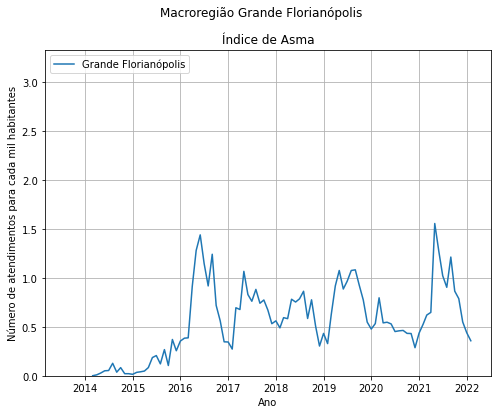

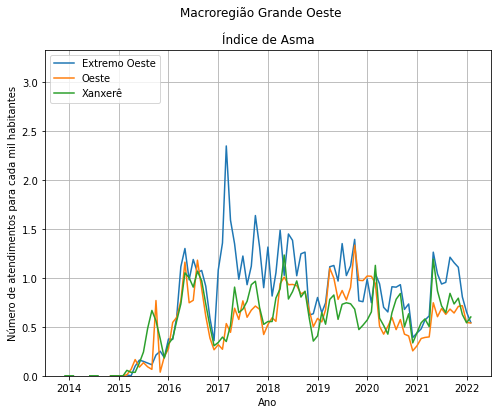

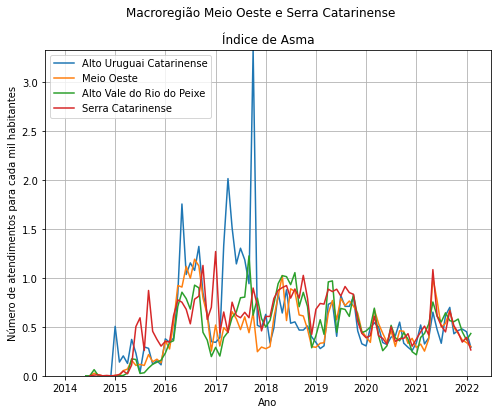

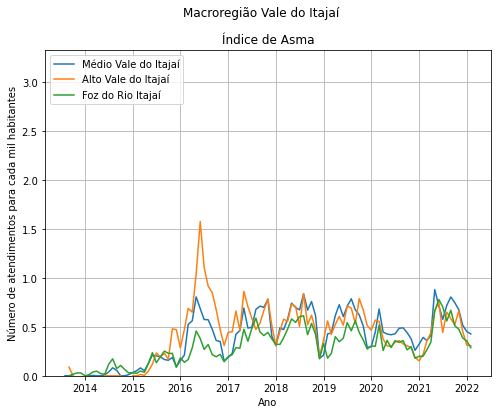

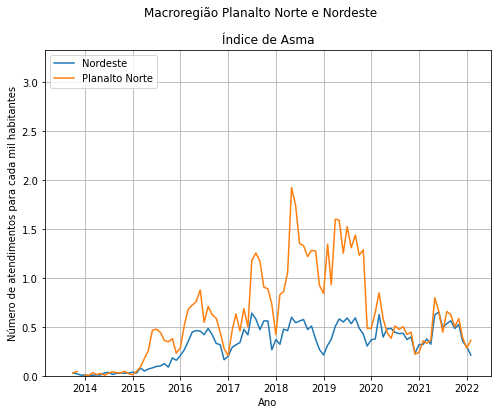

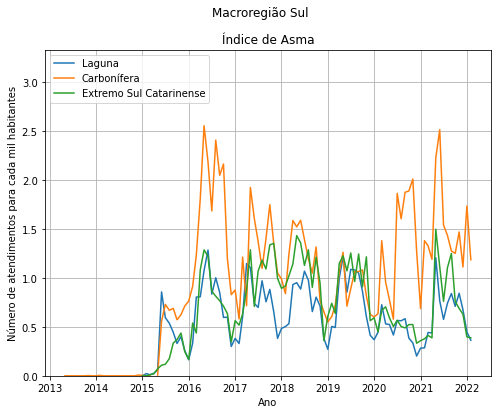

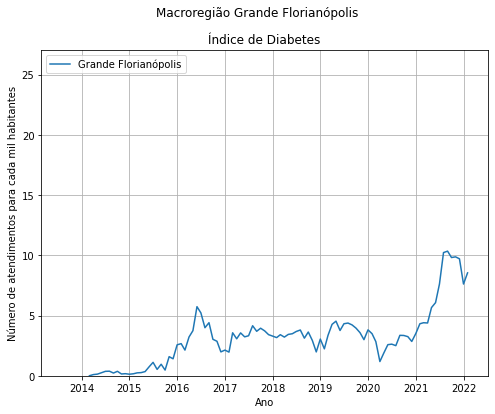

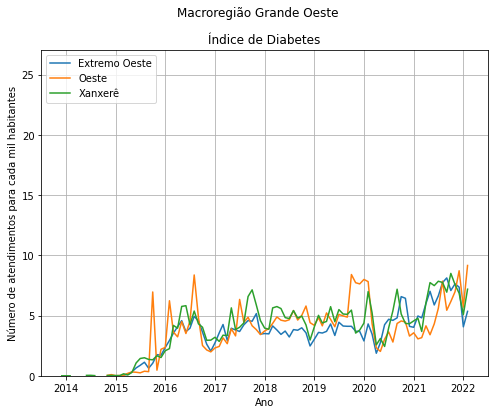

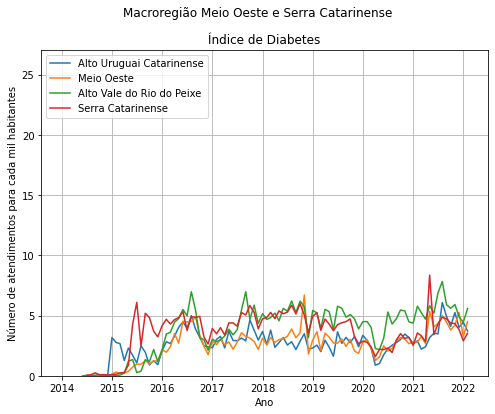

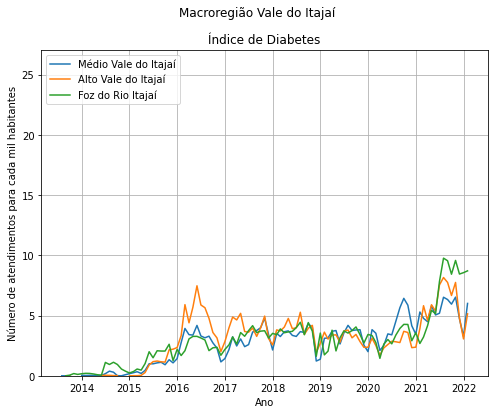

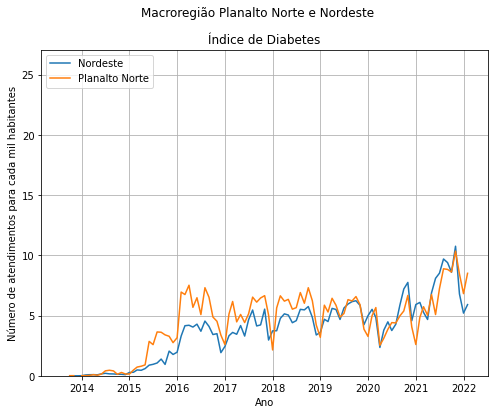

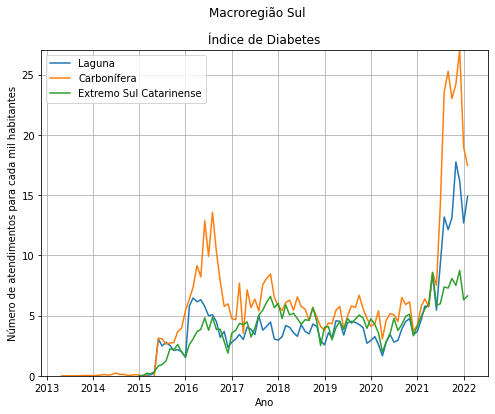

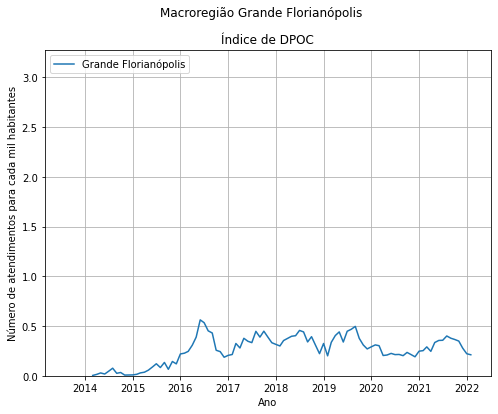

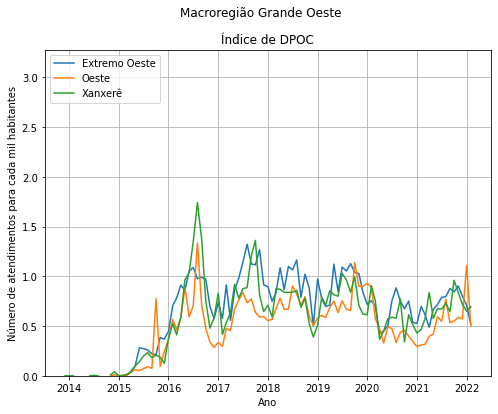

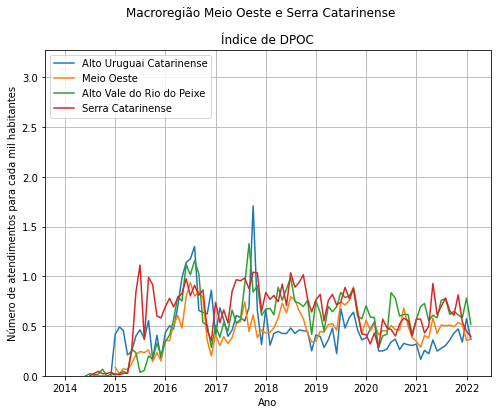

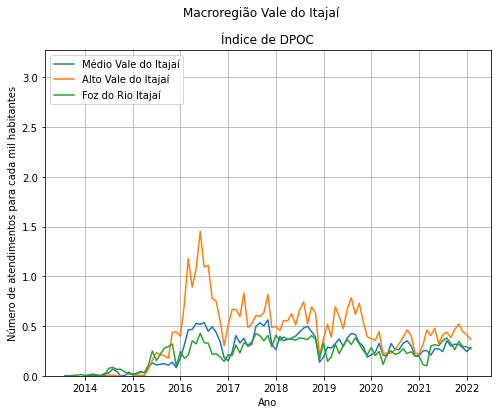

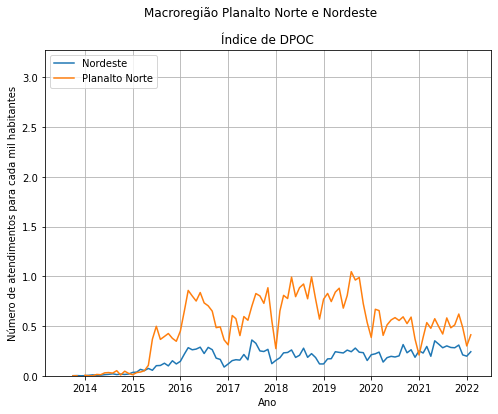

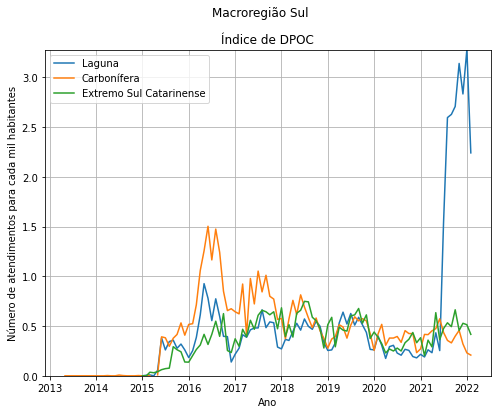

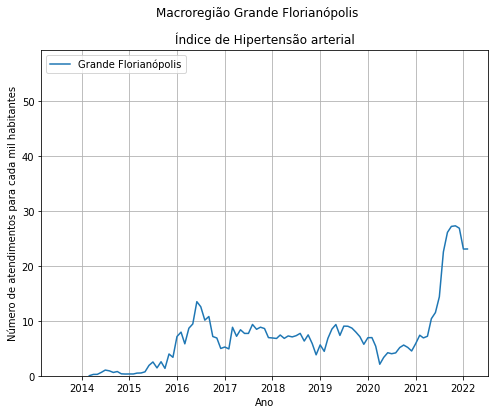

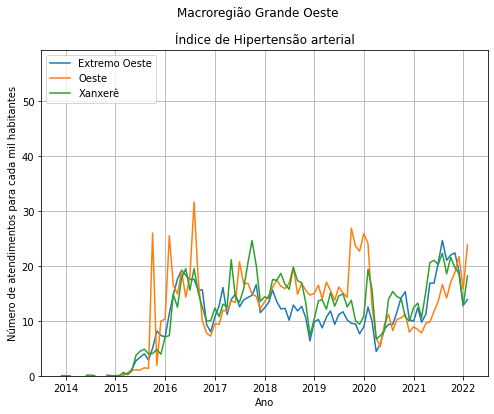

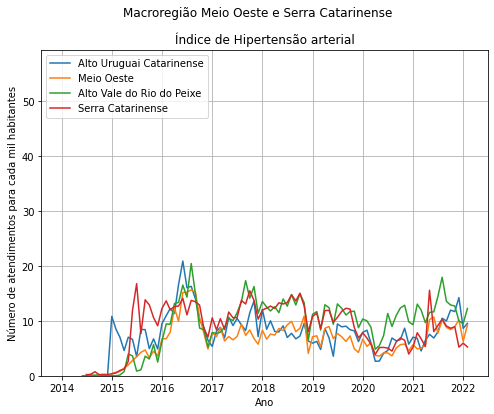

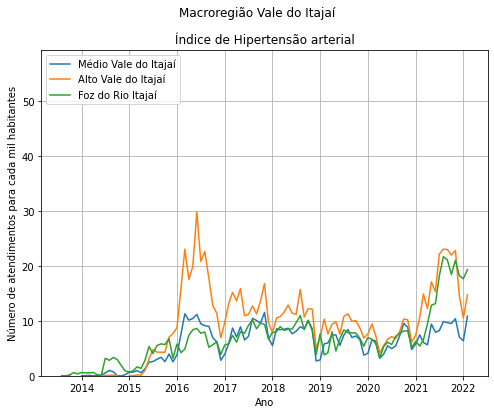

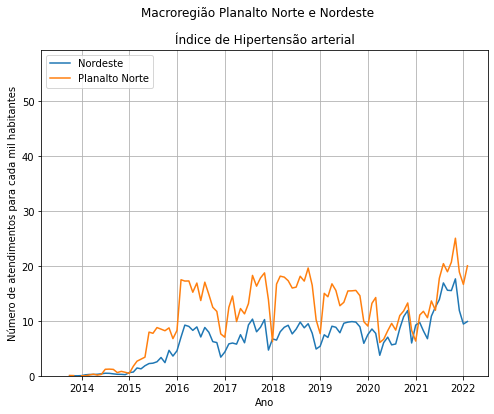

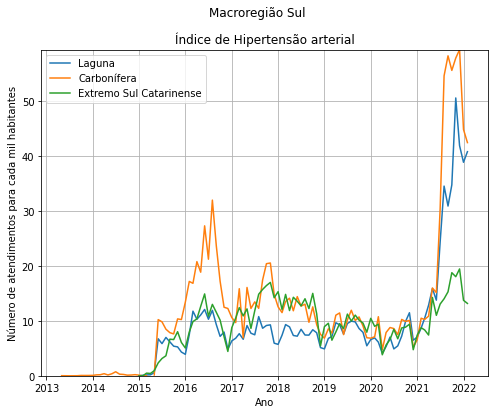

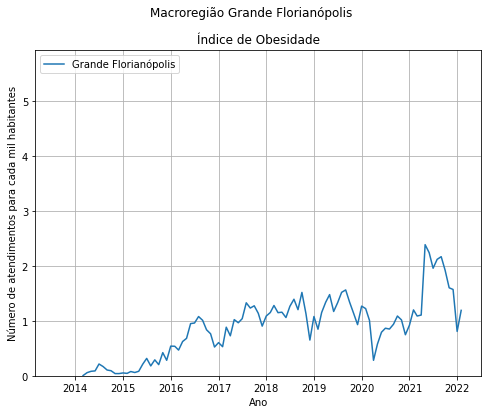

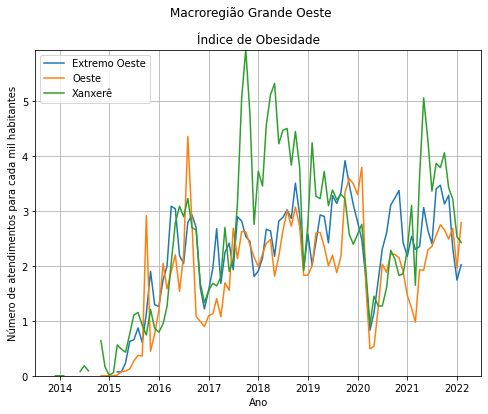

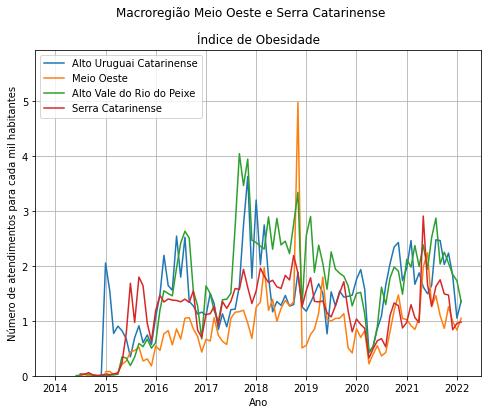

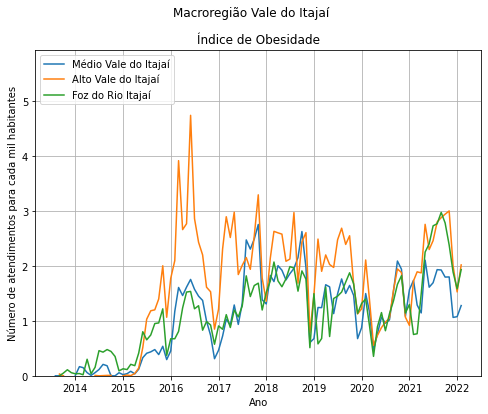

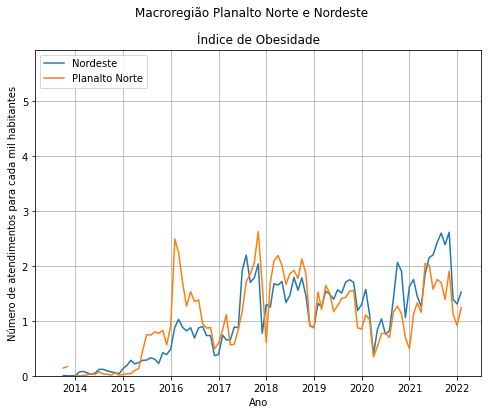

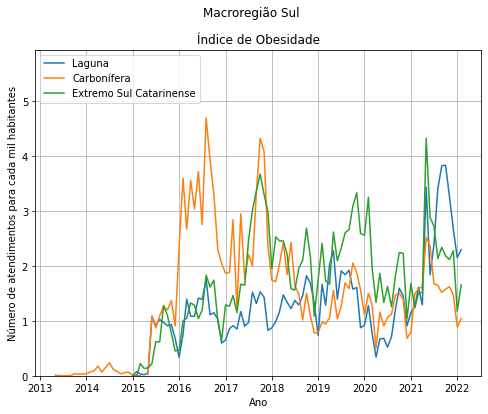

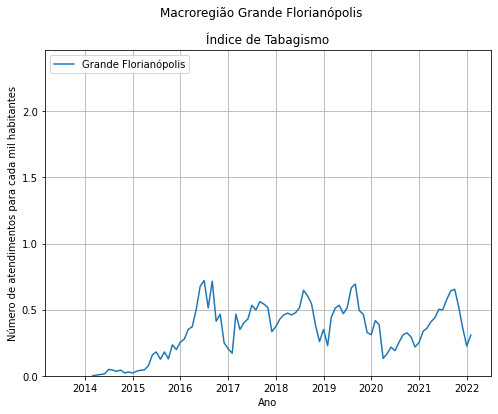

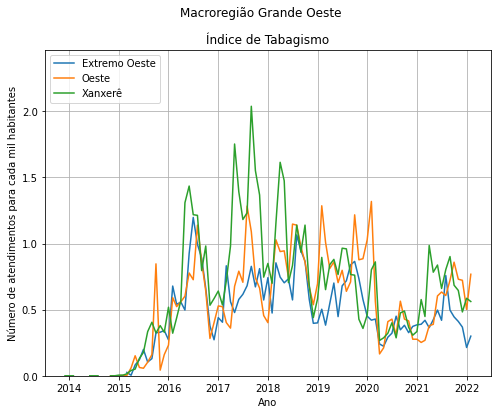

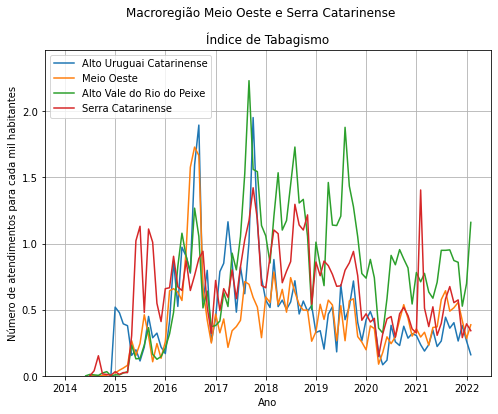

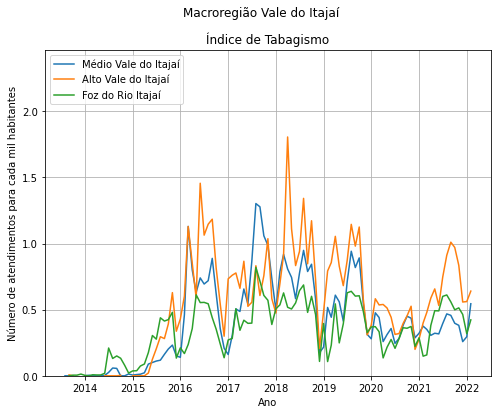

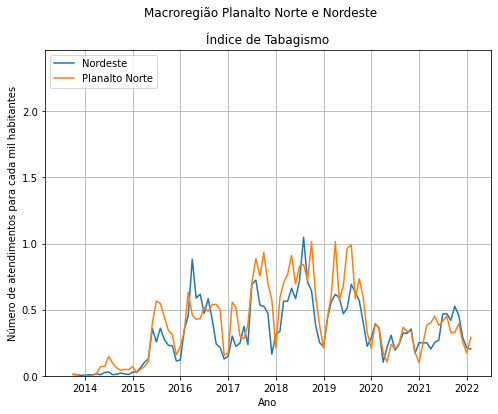

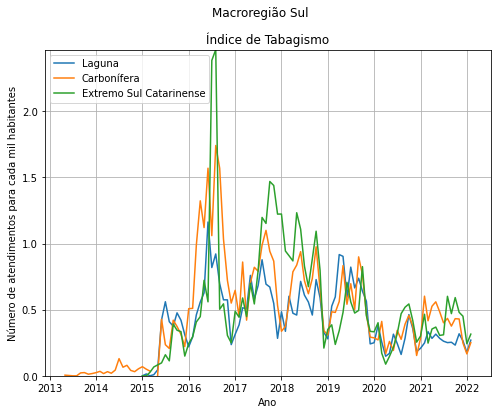

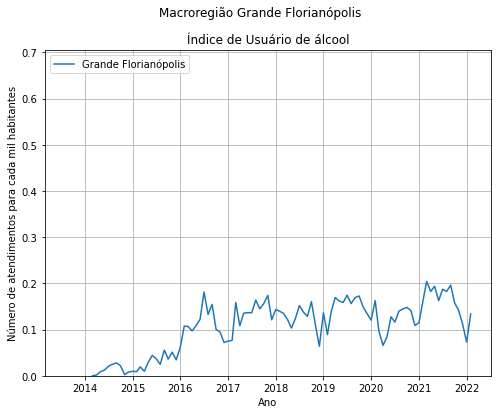

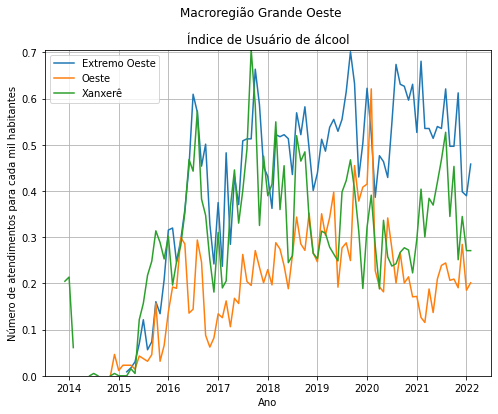

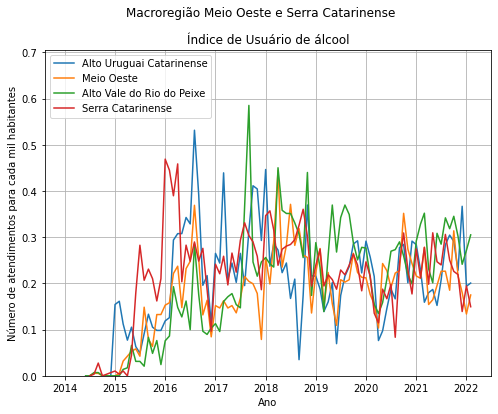

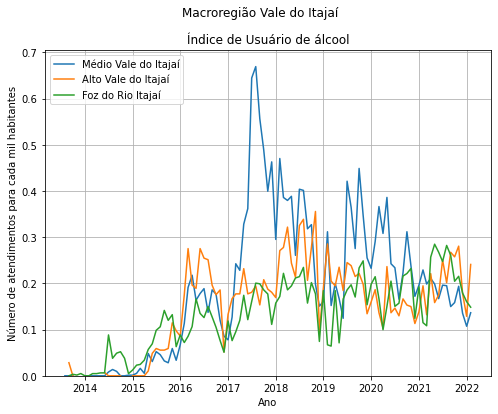

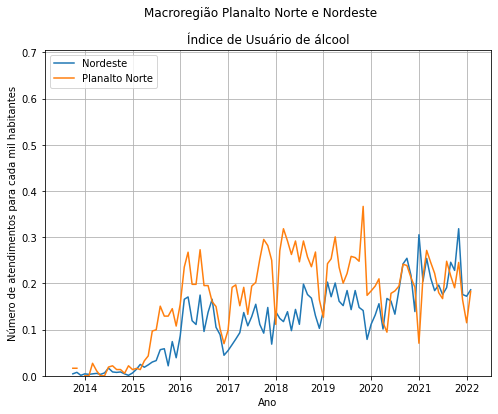

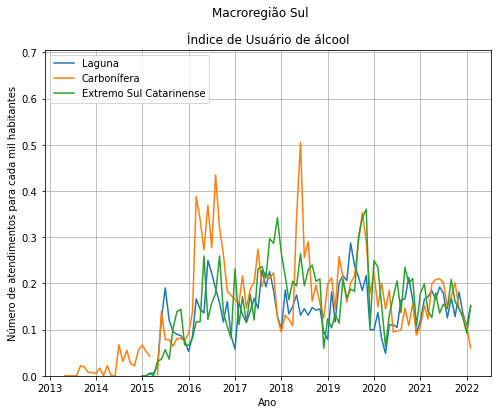

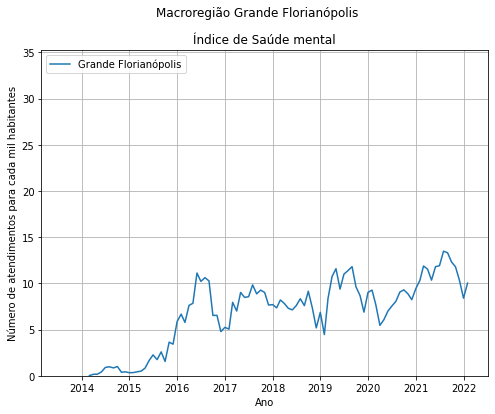

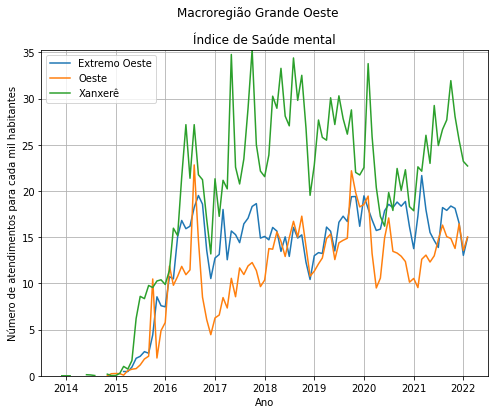

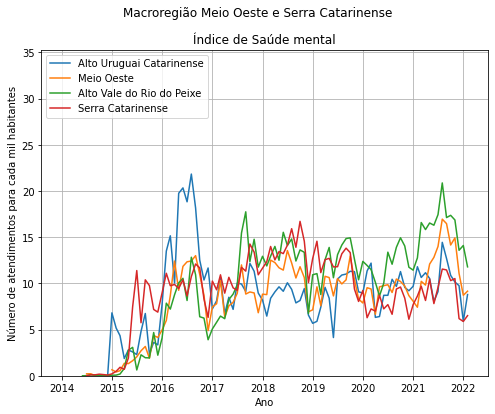

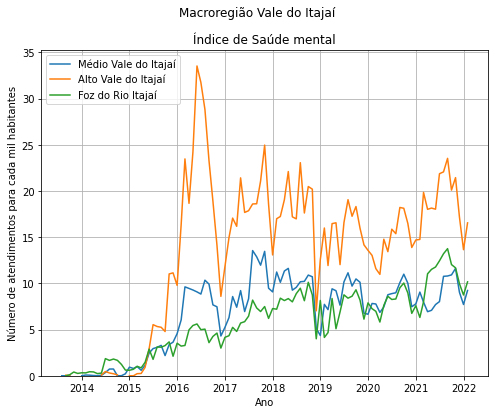

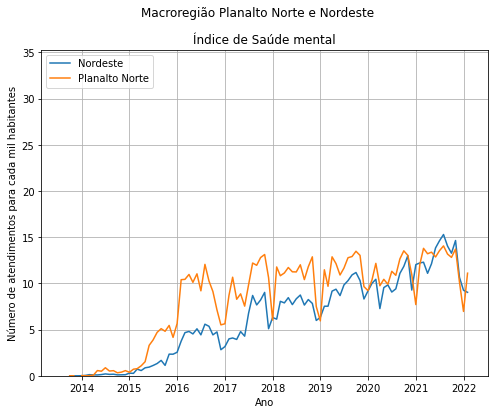

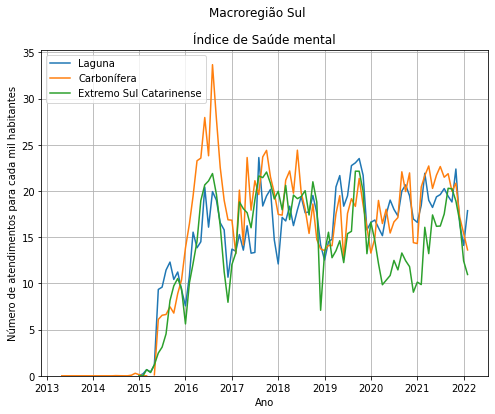

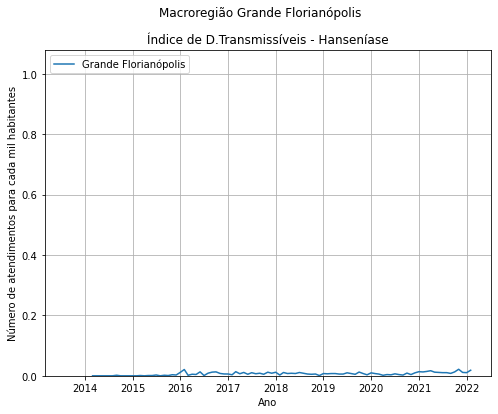

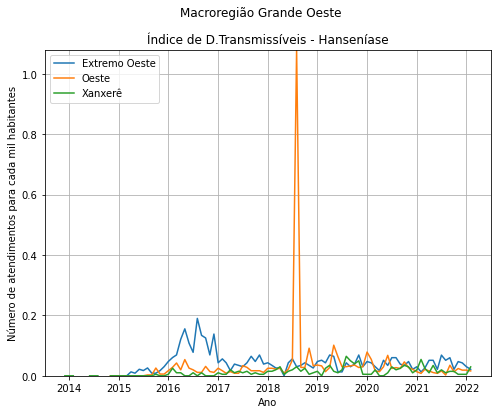

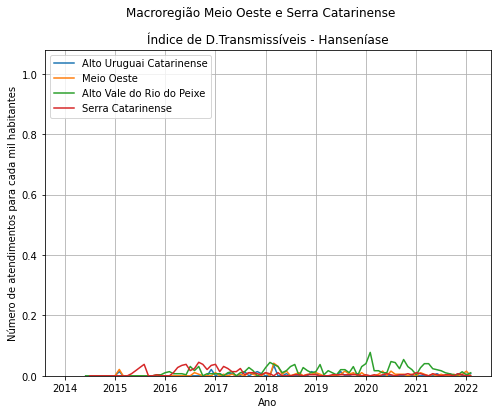

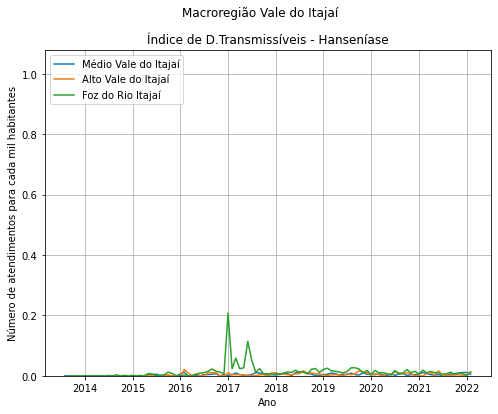

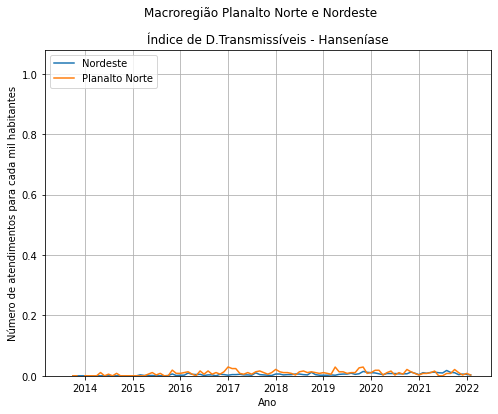

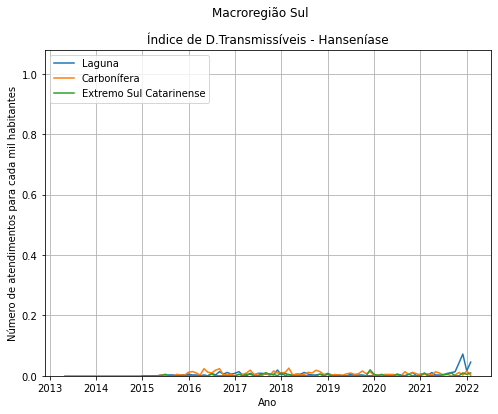

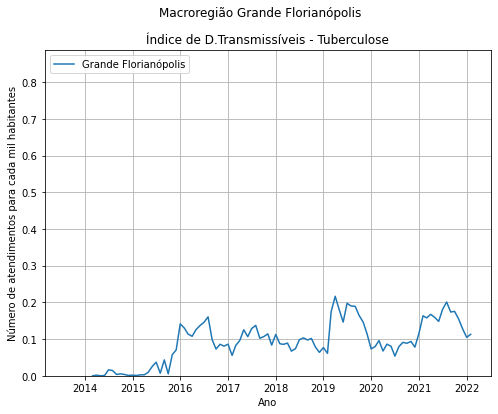

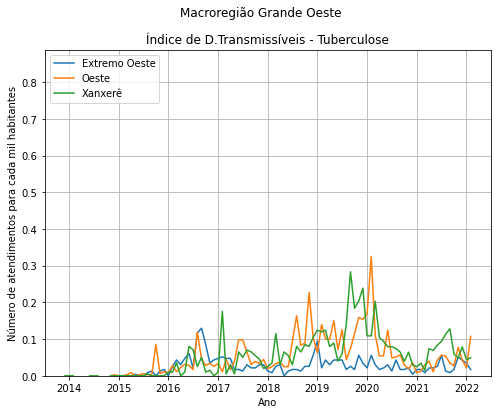

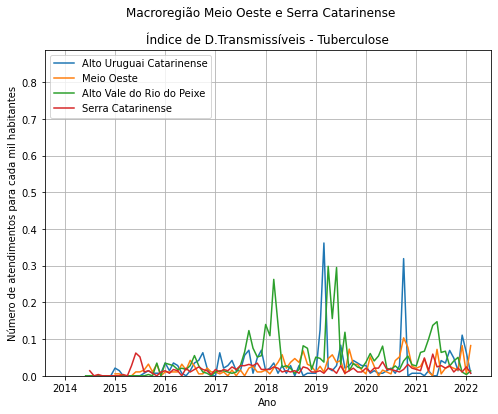

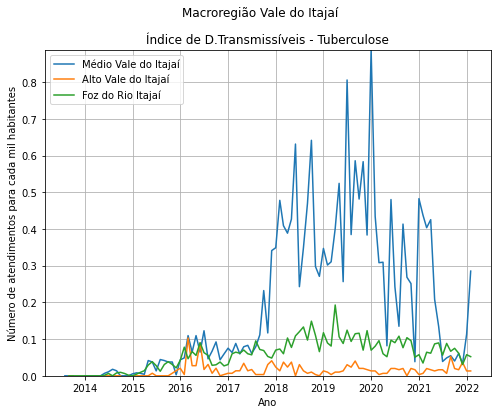

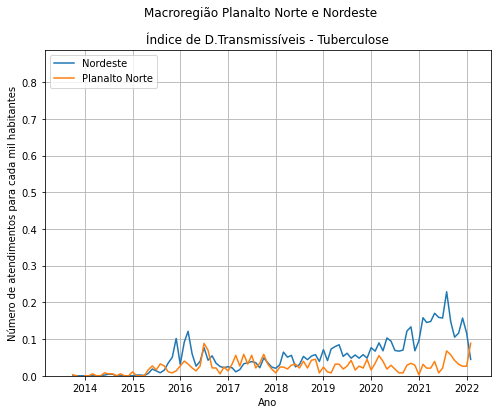

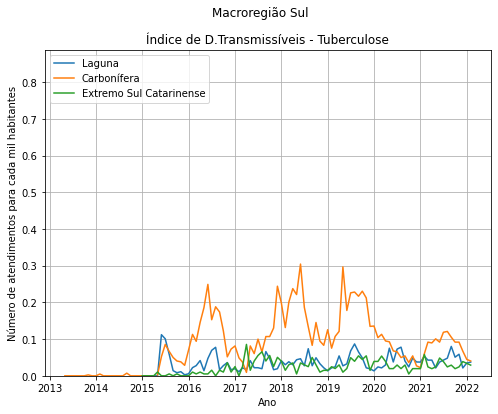

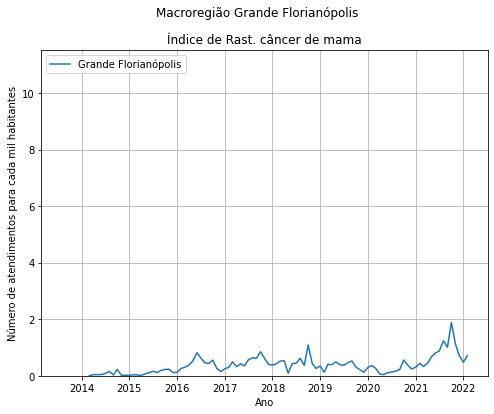

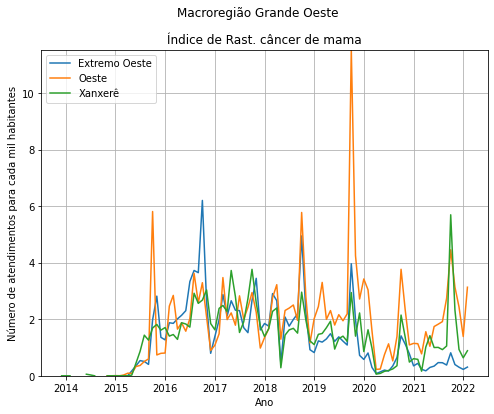

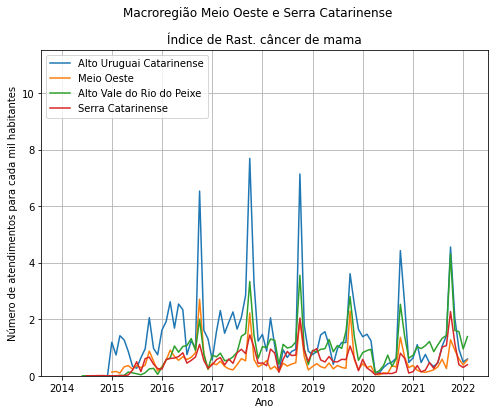

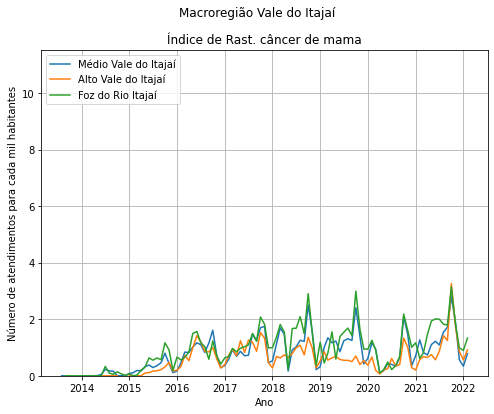

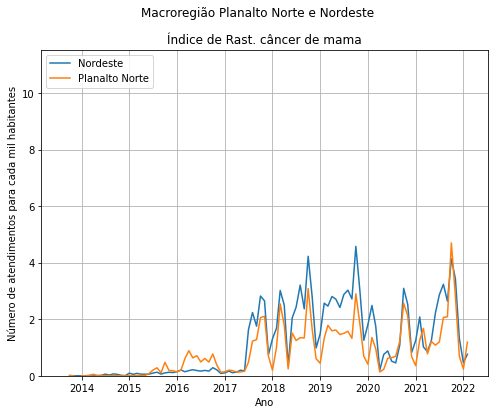

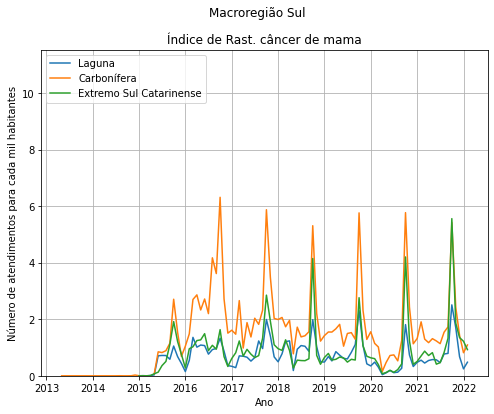

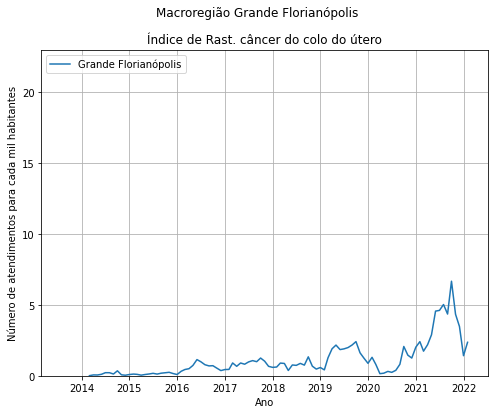

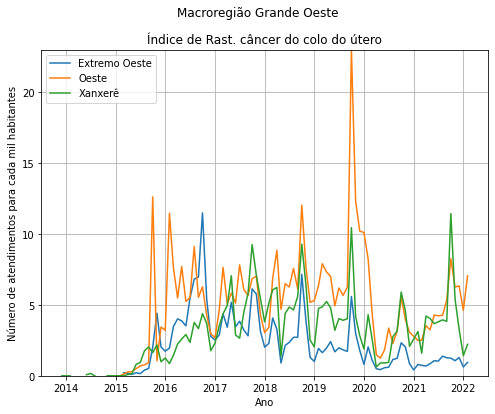

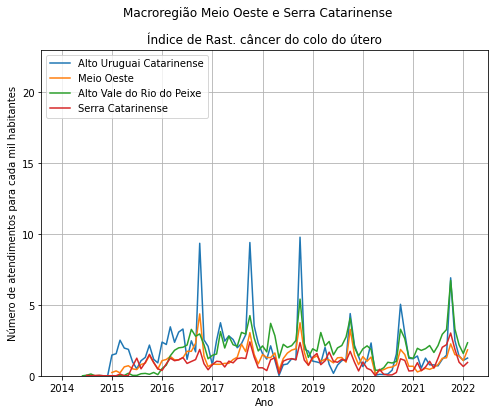

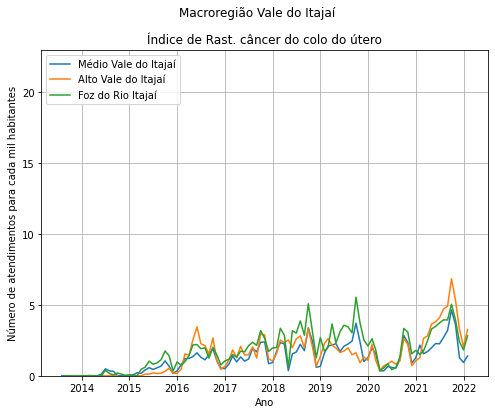

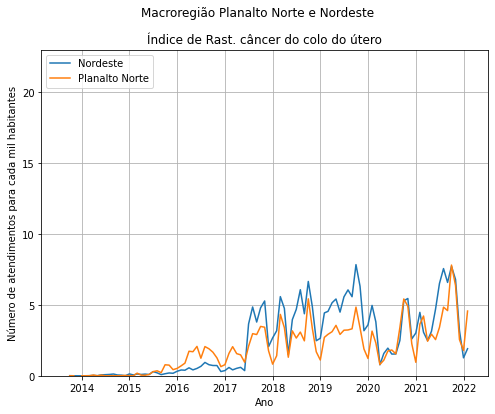

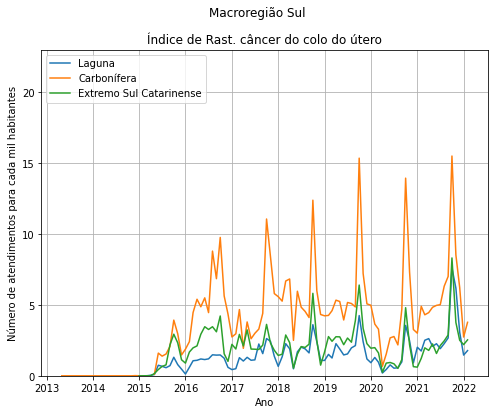

In [20]:
for doenca in doenças_interesse:
    incidencias_regionais = get_indices(doenca)
    ymax = incidencias_regionais.max().max()
    datas = [dt.strptime(str(x), "%Y%m") for x in incidencias_regionais.index.values]

    for x in MACRO_REGIOES:
        fig, ax = plt.subplots(figsize=(8,6))
        for reg in MACRO_REGIOES[x]:
            ax.plot(datas, incidencias_regionais[reg], label=reg)
        ax.set_ylabel("Número de atendimentos para cada mil habitantes")
        ax.set_xlabel("Ano")
        ax.set_title(f"Índice de {doenca}")
        fig.suptitle(f"Macroregião {x}")
        ax.set_ylim((0, ymax))
        ax.legend(loc="upper left")
        ax.grid()
        fig.savefig(f"graficos/{doenca}_{x}.png", dpi=300)


In [9]:
equipes = pd.read_csv("../data/estabelecimentos/equipes.csv")

In [11]:

ST = pd.read_pickle("../parsed-data/estabelecimentos.pd.pkl")
ST.set_index("CNES", inplace=True)
ST["label"] = ST["NOME FANTASIA"]

In [31]:
ceps = pd.read_csv("../data/geoloc/CEPdatabase.csv")
ceps.IBGE = ceps.IBGE // 10

In [32]:
ceps

,altitude,cep,latitude,longitude,logradouro,bairro,complemento,cidade,DDD,IBGE
0,596.0,89700176,-27.234701,-52.021453,Rua Leonel Mosele,Centro,- até 410 - lado par,Concórdia,49.0,420430
1,39.0,88351495,-27.098000,-48.919213,Rua Guilherme Wegner,São Luiz,- lado ímpar,Brusque,47.0,420290
2,12.0,88715000,-28.614820,-49.026000,NaN,NaN,NaN,Jaguaruna,48.0,420880
3,38.0,88811235,-28.694380,-49.388670,Rua Júlio Gaidzinski,Mina Brasil,NaN,Criciúma,48.0,420460
4,8.0,88102100,-27.614190,-48.627086,Rua Delamar José da Silva,Kobrasol,- lado par,São José,48.0,421660
...,...,...,...,...,...,...,...,...,...,...
3994,79.0,89030003,-26.919000,-49.074075,Rua Otto Berner,Itoupava Seca,NaN,Blumenau,47.0,420240
3995,3.0,88070770,-27.564510,-48.512339,Rua José Bonifácio,Canto,NaN,Florianópolis,48.0,420540
3996,884.0,88501320,-27.816000,-50.325288,Rua Pereira Oliveira,Centro,- até 114/115,Lages,49.0,420930
3997,3.0,88085540,-27.631740,-48.509800,Travessa Hamilton Berreta,Itaguaçu,NaN,Florianópolis,48.0,420540


In [51]:
regioes = pd.read_csv("../data/geoloc/regioes-saude.csv")
regioes.set_index("CODIBGE",inplace=True)

In [72]:
def getcnes(reg):
    try:
        return ST.loc[reg.CNES, "lat":"lon"]
    except KeyError:
        print("Erro com CNES", reg.CNES, "IBGE",reg.CODUFMUN)
        registro = ceps.query(f"IBGE == {reg.CODUFMUN}").sample(n=1)
        return [registro.latitude,registro.longitude]


geoequipes = pd.concat([equipes, equipes.apply(getcnes,axis=1,result_type="expand").astype(float)],axis=1)


Erro com CNES 2302195 IBGE 420300
Erro com CNES 2302195 IBGE 420300


In [73]:
geoequipes["municipio"] = geoequipes.CODUFMUN.apply(lambda x: regioes.loc[x,"municipio"].title())
geoequipes["regiao"] = geoequipes.CODUFMUN.apply(lambda x: regioes.loc[x,"REGIAO"].title())

In [44]:
import folium
from folium.plugins import FastMarkerCluster

In [128]:
porregiao = pd.concat([geoequipes[["lat","lon","regiao"]].groupby("regiao").median(), geoequipes.groupby("regiao").count()["CNES"]],axis=1)

In [189]:
perregiaoedit = pd.read_csv("porregiao.csv", sep=";", decimal=",")
perregiaoedit.set_index("regiao",inplace=True)

In [192]:
def retrieve_data(line):
    return line["lat"], line["lon"], line["NOME_EQP"], line["municipio"]


def getcor(cor):
    dicionario = {'laranja': 'orange',
                  'azul': 'blue',
                  'verde': "green",
                  "verdinho": "rgba(120,200,120)",
                  "cinza": "gray",
                  "roxo": "rgba(197 19 197)",
                  }
    return dicionario[cor]


def ping_points():
    m = folium.Map([-27.2958165, -50.5933218],
                   zoom_start=7.4, tiles="OpenStreetMap")
    for reg, serie in perregiaoedit.iterrows():
        cor = getcor(serie.cor)
        folium.Marker([serie.lat, serie.lon], icon=folium.DivIcon(
            icon_size=(120, 50),
            html=f"""<div style='background-color: white;
                border-radius: 15px;
                border: 1px solid black;
                width: 120px;
                height: 68px;
                text-align: center;
                padding-top: 10px;'>
                <b style="color: {cor};">{reg}</b><br>{int(serie.CNES)}</div>
                """)).add_to(m)
    return m


In [193]:
m = ping_points()
m.save("equipes.html")

In [151]:
porregiao.to_csv("porregiao.csv",sep=";")

In [100]:
# geoequipes.groupby("municipio").count()["CNES"].to_csv("confere.csv", )
# conferido

Index(['Alto Uruguai Catarinense', 'Alto Vale Do Itajaí',
       'Alto Vale Do Rio Do Peixe', 'Carbonífera', 'Extremo Oeste',
       'Extremo Sul Catarinense', 'Foz Do Rio Itajaí', 'Grande Florianópolis',
       'Laguna', 'Meio Oeste', 'Médio Vale Do Itajaí', 'Nordeste', 'Oeste',
       'Planalto Norte', 'Serra Catarinense', 'Xanxerê'],
      dtype='object', name='regiao')

In [112]:
m = folium.Map([-27.2958165, -50.5933218],
               zoom_start=7.4, tiles="OpenStreetMap")
ponto = folium.Marker([-27, -50], icon=folium.DivIcon(
    icon_size=(50, 50), icon_anchor=(0, 0),
    html="""<div style='background-color: rgba(230, 0, 0, 0.5);
    border-radius: 30px;
    width: 60px;
    height: 60px;
    text-align: center;
    padding-top: 10px;'>
    <b>Bossa</b></div>
    """)).add_to(m)

m
